# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


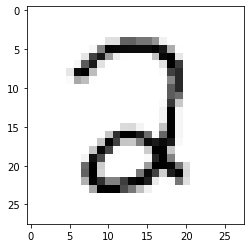

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2264
Training Accuracy: 0.7994, Testing Accuracy: 0.8170



Epoch 10, Loss 0.0508
Training Accuracy: 0.9467, Testing Accuracy: 0.9572



Epoch 20, Loss 0.0376
Training Accuracy: 0.9580, Testing Accuracy: 0.9632



Epoch 30, Loss 0.0322
Training Accuracy: 0.9629, Testing Accuracy: 0.9677



Epoch 40, Loss 0.0291
Training Accuracy: 0.9665, Testing Accuracy: 0.9698



Epoch 50, Loss 0.0269
Training Accuracy: 0.9690, Testing Accuracy: 0.9713



Epoch 60, Loss 0.0253
Training Accuracy: 0.9708, Testing Accuracy: 0.9728



Epoch 70, Loss 0.024
Training Accuracy: 0.9723, Testing Accuracy: 0.9743



Epoch 80, Loss 0.0228
Training Accuracy: 0.9740, Testing Accuracy: 0.9743



Epoch 90, Loss 0.0219
Training Accuracy: 0.9751, Testing Accuracy: 0.9738



Epoch 100, Loss 0.021
Training Accuracy: 0.9762, Testing Accuracy: 0.9748



Epoch 110, Loss 0.0202
Training Accuracy: 0.9774, Testing Accuracy: 0.9753



Epoch 120, Loss 0.0195
Training Accuracy: 0.9784, Testing Accuracy: 0.9753



Epoch 130, Loss 0.0188
Training Accuracy: 0.9791, Testing Accuracy: 0.9758



Epoch 140, Loss 0.0182
Training Accuracy: 0.9796, Testing Accuracy: 0.9768



Epoch 150, Loss 0.0177
Training Accuracy: 0.9806, Testing Accuracy: 0.9773



Epoch 160, Loss 0.0171
Training Accuracy: 0.9811, Testing Accuracy: 0.9773



Epoch 170, Loss 0.0166
Training Accuracy: 0.9818, Testing Accuracy: 0.9768



Epoch 180, Loss 0.0161
Training Accuracy: 0.9825, Testing Accuracy: 0.9768



Epoch 190, Loss 0.0156
Training Accuracy: 0.9833, Testing Accuracy: 0.9768



Epoch 200, Loss 0.0152
Training Accuracy: 0.9842, Testing Accuracy: 0.9768



Epoch 210, Loss 0.0147
Training Accuracy: 0.9851, Testing Accuracy: 0.9778



Epoch 220, Loss 0.0144
Training Accuracy: 0.9854, Testing Accuracy: 0.9788



Epoch 230, Loss 0.014
Training Accuracy: 0.9858, Testing Accuracy: 0.9793



Epoch 240, Loss 0.0136
Training Accuracy: 0.9862, Testing Accuracy: 0.9798



0.004809554244312585

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2378
Training Accuracy: 0.6645, Testing Accuracy: 0.6794



Epoch 10, Loss 0.1073
Training Accuracy: 0.8959, Testing Accuracy: 0.9108



Epoch 20, Loss 0.0813
Training Accuracy: 0.9237, Testing Accuracy: 0.9355



Epoch 30, Loss 0.0695
Training Accuracy: 0.9336, Testing Accuracy: 0.9471



Epoch 40, Loss 0.0625
Training Accuracy: 0.9400, Testing Accuracy: 0.9526



Epoch 50, Loss 0.0578
Training Accuracy: 0.9423, Testing Accuracy: 0.9561



Epoch 60, Loss 0.0544
Training Accuracy: 0.9453, Testing Accuracy: 0.9582



Epoch 70, Loss 0.0517
Training Accuracy: 0.9483, Testing Accuracy: 0.9607



Epoch 80, Loss 0.0496
Training Accuracy: 0.9493, Testing Accuracy: 0.9597



Epoch 90, Loss 0.0479
Training Accuracy: 0.9513, Testing Accuracy: 0.9612



Epoch 100, Loss 0.0464
Training Accuracy: 0.9522, Testing Accuracy: 0.9627



Epoch 110, Loss 0.0452
Training Accuracy: 0.9529, Testing Accuracy: 0.9637



Epoch 120, Loss 0.0441
Training Accuracy: 0.9540, Testing Accuracy: 0.9637



Epoch 130, Loss 0.0432
Training Accuracy: 0.9553, Testing Accuracy: 0.9637



Epoch 140, Loss 0.0423
Training Accuracy: 0.9563, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0415
Training Accuracy: 0.9567, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0409
Training Accuracy: 0.9568, Testing Accuracy: 0.9652



Epoch 170, Loss 0.0402
Training Accuracy: 0.9573, Testing Accuracy: 0.9652



Epoch 180, Loss 0.0397
Training Accuracy: 0.9581, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0391
Training Accuracy: 0.9584, Testing Accuracy: 0.9662



Epoch 200, Loss 0.0387
Training Accuracy: 0.9589, Testing Accuracy: 0.9667



Epoch 210, Loss 0.0382
Training Accuracy: 0.9589, Testing Accuracy: 0.9672



Epoch 220, Loss 0.0378
Training Accuracy: 0.9594, Testing Accuracy: 0.9677



Epoch 230, Loss 0.0374
Training Accuracy: 0.9594, Testing Accuracy: 0.9688



Epoch 240, Loss 0.037
Training Accuracy: 0.9600, Testing Accuracy: 0.9688



0.04417807354775171

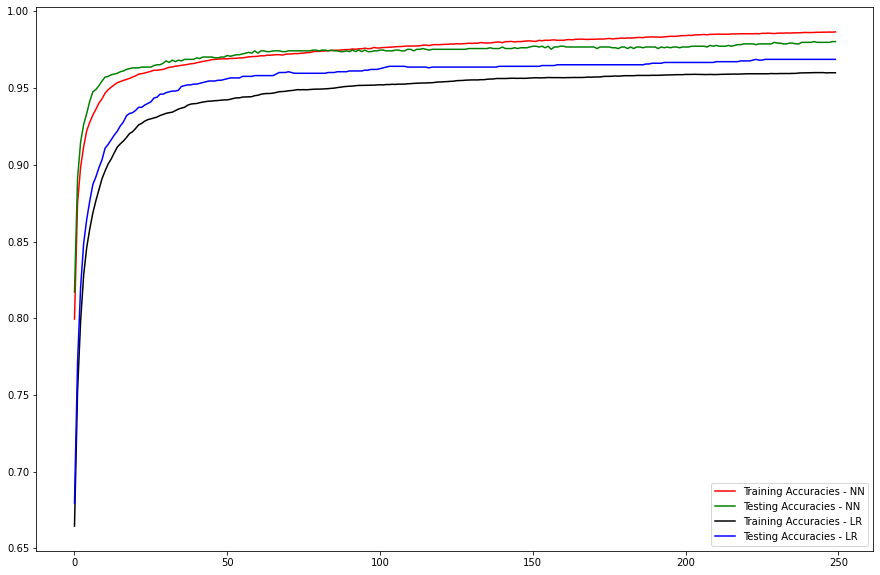

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

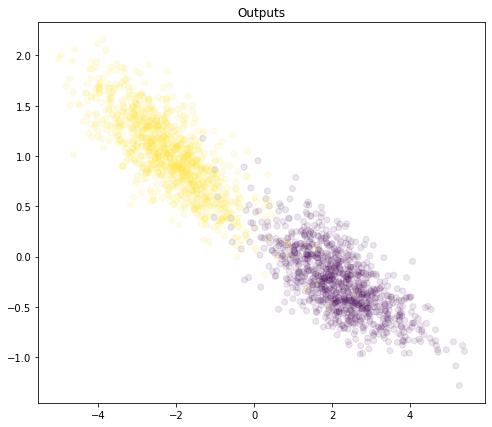

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

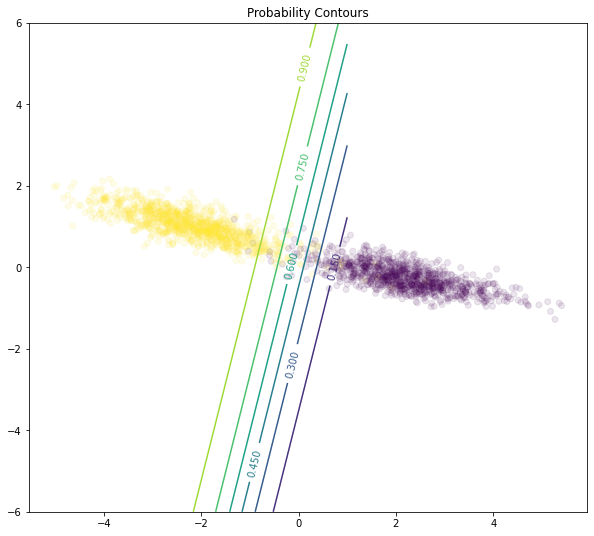

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );